# Problem description from Frank
One task that you can already start working on (since this was part of our first meeting)
is a numerical example of one complete forward backward learning cycle through a very simple
classification network consisting of a feature extraction/learning part (CNN with conv. and
pooling layers) and a classification part (FCNN with at least one fully-connected/dens layer)

To get you started on something practical (first task) you should look under “Files”
here: 10_numExampleOrVideo(channel) > 2022 > 2022-P0> 2022-P0-T1_FCNNs & CNNs -F&B pass”
Here you will find the file“Guide_Part2.pdf” that will give you more information about the task.
There is also a folder “00_Examples_Given” that provides you with some worked out examples.


# TODO:


Base the work off the T3.1 and lecture slides. There does not need to be any "point" behind the network per say, since the
"only important" part here is the math.

1. Create the definition of the network as a parameter list
2. Create helper functions for activations
3. Create matrix visualizer
3. 

## DONE 1. Create simple FCNN module
May want to look at https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795 as well
## 2. Create CNN w. conv module
https://towardsdatascience.com/lets-code-convolutional-neural-network-in-plain-numpy-ce48e732f5d5
## 3. Connect CNN->FCNN
## 4. Numerical example of forward pass
## 5. Numerical example of backward pass






In [48]:
# Imports here

import numpy as np

import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Callable


from __future__ import annotations
from itertools import product



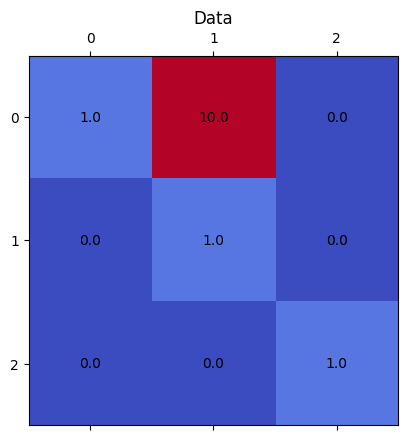

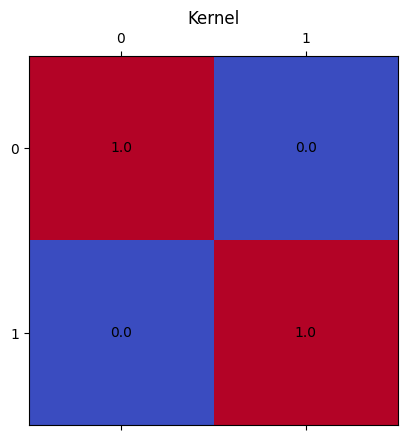

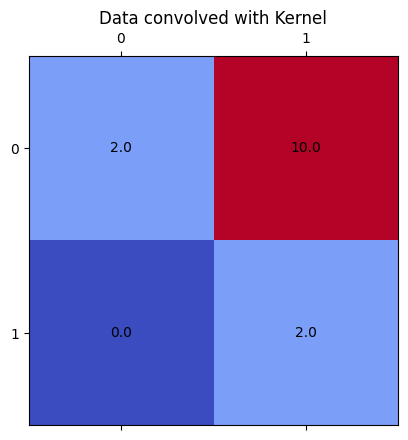

In [68]:

from __future__ import annotations
from itertools import product

class Matrix2D():

    def __init__(self, array: np.ndarray):
        assert len(array.shape) == 2, "Input array must be 2D!"

        self.value: np.ndarray = array
        self.nrow: int = array.shape[0]
        self.ncol: int = array.shape[1] 

    def draw(self, title: str = "") -> None:
        """Display a visualization of the matrix values

        See: https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap
        """
        fig, ax = plt.subplots()

        ax.matshow(self.value, cmap=plt.cm.coolwarm)

        for y, x in np.ndindex(self.value.shape):
            ax.text(y, x, str(self.value[x, y]), va='center', ha='center')
        ax.set_title(title)


    def convolve2D(self, kernel: Matrix2D, bias: float = 0, stride: int = 1) -> Matrix2D:
        assert stride != 0, "Stride cannot be zero!"

        output_width: int = (self.nrow - kernel.nrow) // stride + 1
        output_height: int = (self.ncol - kernel.ncol) // stride + 1

        output_image = np.zeros((output_height, output_width))

        for col, row in product(range(0, output_width, stride), range(0, output_height, stride)):
            output_image[row, col] = \
                self.value[row:row+kernel.ncol, col:col+kernel.nrow].flatten() \
                @ kernel.value.flatten() \
                + bias 

        return Matrix2D(output_image)






arr = np.eye(3)
arr[0, 1] = 10
X = Matrix2D(arr)
K = Matrix2D(np.eye(2))
X.draw("Data")
K.draw("Kernel")
O = X.convolve2D(K)
O.draw("Data convolved with Kernel")



In [46]:

# TODO: Make compatible with arrays and matrices?

# TODO: Alternatively remove class and just pass bool

class Activation():
    def __init__(self, backward: bool = False):
        self.backward = backward

    def relu(self, value: float):
        """ReLU activation"""
        act = value > 0

        if self.backward:
            return act * 1

        return act * value

    def sigmoid(self, value: float):
        """Sigmoid activation"""
        act = np.exp(value) / (1 + np.exp(value))

        if self.backward:
            return act * (1 - act)

        return act

act = Activation()

x = 10.0

print(act.relu(x))
act.backward = True
print(act.relu(x))

    

10.0
1


In [39]:

class Float:
    """A wrapper class for numbers in the network that adds additional
    functionality like storing the gradient to allow for easy backward
    propagation
    """

    def __init__(self, value, children=()):
        self.value = value
        self.grad = 0
        # internal variables used for autograd graph construction
        self.backward = lambda: None
        self.children = set(children)

    def __cast_to_self(self, other):
        return other if isinstance(other, Float) else Float(other)

    def __add__(self, other) -> Float:
        other = self.__cast_to_self(other)
        out = Float(self.value + other.value, (self, other))

        def backward() -> None:
            self.grad += out.grad
            other.grad += out.grad

        out.backward = backward
        
        return out

    def __mul__(self, other) -> Float:
        other = self.__cast_to_self(other)
        out = Float(self.value * other.value, (self, other))

        def backward() -> None:
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        
        out.backward = backward

        return out

    def __pow__(self, other) -> Float:
        other = self.__cast_to_self(other)
        out = Float(self.value**other, (self,))

        def backward() -> None:
            self.grad += (other * self.value**(other - 1)) * out.grad

        out.backward = backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other
        
    def __rmul__(self, other):
        return self * other

    def __rsub__(self, other):
        return other + (-self)

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __repr__(self):
        return f"Float(data={self.value}, grad={self.grad})"


    # Below is a collection of activation functions

    def relu(self) -> Float:
        value = max(0, self.value)
        out = Float(value, (self,))

        def backward() -> None:
            self.grad += (value > 0) * out.grad

        out.backward = backward

        return out

    def tanh(self) -> Float: 
        raise NotImplementedError

    def abs(self) -> Float:
        raise NotImplementedError
    
    def linear(self) -> Float:
        raise NotImplementedError

    
    # The main workhorse of the backwards pass

    def backward_pass(self):
        """The main algorithm for a backwards pass. Works by topologically
        sorting all connected nodes then iteratively and reversely calling
        backwards on the sorted list.
        """
        nodes_sorted = []
        nodes_visited = []

        def topological_sort(node) -> None:
            if node not in nodes_visited:
                nodes_visited.append(node)

                for child in node.children:
                    topological_sort(child)

                nodes_sorted.append(node)

        topological_sort(self)

        self.grad = 1 # Need to set this to non-zero, else all grads will be 0
        for node in reversed(nodes_sorted):
            node.backward()


In [5]:
class Base():
    
    def reset(self):
        for p in self.p():
            p.grad = 0

    def p(self):
        return []

In [6]:

class Neuron(Base):
    
    def __init__(self, n_inputs, f=None):
        """Create a neuron with n inputs.
        
        Optionally specify an activation function.
        If no activation function is set, a default one
        will be set. Right now that is f(x) = x
        """
        self.w = [Float(np.random.uniform(-1, 1)) for _ in range(n_inputs)]
        self.b = Float(np.random.uniform())
        
        if f is None:
            self.f = lambda x : x # Linear
            #self.f = lambda x : max(x, 0) #ReLU
        else:
            self.f = f
    
    def z(self, x):
        """Calculate the pre-activation neuron output"""
        return x@self.w.T + self.b
    
    def a(self, x):
        """Calculate the post-activation neuron output"""
        return self.f(self.z(x))

    def p(self):
        """Return the weights of the neuron"""
        return [self.b] + self.w

    
# Test
#N = 3
#n = Neuron(N)
#x = np.random.rand(N)
#print(n.a(x))


In [7]:
class Layer(Base):
    
    def __init__(self, n_neurons, n_inputs):
        """Create a layer of n_neurons
        
        The amount of inputs to the neurons will also need to be specified.
        """
        self.neurons = [Neuron(n_inputs) for _ in range(n_neurons)]
        
    def out(self, x):
        """Return the vector of outputs of the layer"""
        return [n.out(x) for n in self.neurons]

    def p(self):
        """Return the parameters for all the neurons in the layer"""
        return [p for n in self.neurons for p in n.p()]
        
    
        
    

In [8]:
class FCNN(Base):
    
    def __init__(self, n_inputs, n_outputs):
        """Create a fully-connected network of n layers
        """
        sizes = [n_inputs] + n_outputs
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(n_outputs))]
        
        
    def out(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def p(self):
        [p for l in self.layers for p in l.p()]
